## How to access Virgo raw data in the CIT cluster?

(a summary and some discussion is available at https://git.ligo.org/virgo/detchar/detchar-help/-/issues/8)

### SciToken permissions

Proprietary data requires special access, which is granted through a [SciToken](https://computing.docs.ligo.org/guide/auth/scitokens/). This SciToken should be issued at each new login via 
```bash
htgettoken -a vault.ligo.org --scopes read:/virgo,read:/ligo
``` 

Even better, the arguments can be saved in an environmental variable `HTGETTOKENOPTS` and then then we just need to run `htgettoken`:
```bash
export HTGETTOKENOPTS="-a vault.ligo.org --scopes read:/virgo,read:/ligo"
# Or alternatively, add the previous line to the .bash_profile file
htgettoken

### CVMFS data (retired)

Previously, proprietary data was available in CIT via CFVMS, but **since August 2025, data access through CVMFS has been retired**: https://computing.docs.ligo.org/guide/cvmfs/#igwn-data

### Getting data through OSDF

Now, data is accessed through OSDF: https://computing.docs.ligo.org/guide/data/distribution/#access

Data is accessed using `pelican` (available in the `igwn` environment and instalable from `conda-forge`) like:
```bash
pelican object get osdf:///igwn/ligo/README README
```
This copies the README file from OSDF to your base path. 

**There is no "in-place" or remote-file handle.**  
You can use `ls` to list the contents of a given "directory", like:
```bash
pelican object ls osdf:///igwn/virgo/frames/O4/HoftOnline
```

### Finding the relevant frame files

There is a folder for each run at `/osdf/virgo.storage.igwn.org/igwn/virgo/frames/`.  
Now, there are some differences between O3 and O4 data. In both cases, the data is stored in `.gwf` files which span 2000 seconds of data, organized in subfolders with typically 50 files each, i.e. 1000,000 seconds: 
- for O3 data, the frame files are under `O3/V1Online/`. Each subfolder is named `V-V1Online-xxxx`, where `xxxxx` are the first five digits of the initial GPS time of the frame. Each of these subfolders contains the corresponding frame files, which are named `V-V1Online-xxxxxxxxxx-2000.gwf`, where `xxxxxxxxxx` is the starting GPS time of the frame.
- for O4 data, the frame files are under `O4/HoftOnline/`. Each subfolder is named `V-HoftOnline-xxxx`, where `xxxxx` are the first five digits of the initial GPS time of the frame. Each of these subfolders contains the corresponding frame files, which are named `V-HoftOnline-xxxxxxxxxx-2000.gwf`, where `xxxxxxxxxx` is the starting GPS time of the frame.

*Example 1:* Where is data from the **O3 GPS time 1238166408**  stored?  
`/osdf/virgo.storage.igwn.org/igwn/virgo/frames/O3/V1Online/V-V1Online-12381/V-V1Online-1238166000-2000.gwf`

*Example 2:* Where is data from the **O4 GPS time 1384625914**  stored?  
`/osdf/virgo.storage.igwn.org/igwn/virgo/frames/O4/HoftOnline/V-HoftOnline-13851/V-HoftOnline-1385160000-2000.gwf`

### ceph mirror

While writing this tutorial, I found that the data is also stored in `ceph/mirror/frames`, following a similar structure.  
In this case, we can load files directly.

## It can be a lot easier
There are tools to make our life a lot easier, like `gwdatafind`, `lalframe` and `gwpy`.

### 1) Finding the frames for a given GPS time/interval

In the command line:
```bash
gw_data_find -o V --type V1Online -s 1238166408 -e 1238166408
```
where "V" is the detector, "V1Online" is the frame type, and then we have the start and end of the period we want to access. 
Note that for O3 you use "V1Online" and for O4 you use "HoftOnline".

In [45]:
# in python
from gwdatafind import find_urls

paths = find_urls("V", "V1Online", 1238166408, 1238166408)
print(paths)

# to access the data, we remove the "file://localhost/" from the beginning
proper_paths = [path.replace("file://localhost", "") for path in paths]
print(proper_paths)

['file://localhost/ceph/mirror/frames/O3/V1Online/V-V1Online-12381/V-V1Online-1238166000-2000.gwf']
['/ceph/mirror/frames/O3/V1Online/V-V1Online-12381/V-V1Online-1238166000-2000.gwf']


### 2) Listing available channels in frame files

In the command line:
```bash
FrChannels $frame_path
```
where $frame_path is the path we get from `gw_data_find`.

In [47]:
# in python
from lalframe.utils.frtools import get_channels

channels = get_channels("/ceph/mirror/frames/O3/V1Online/V-V1Online-12381/V-V1Online-1238166000-2000.gwf")
print("\n".join(channels))

V1:DQ_ANALYSIS_STATE_VECTOR
V1:DQ_ANALYSIS_STATE_VECTOR_ORIG
V1:DQ_SEGONLINE_STATE_VECTOR
V1:DQ_VETO_CWB
V1:DQ_VETO_GSTLAL
V1:DQ_VETO_MBTA
V1:DQ_VETO_PYCBC
V1:DQ_VETO_TEST
V1:Hrec_STATE_VECTOR
V1:Hrec_hoft_16384Hz
V1:Hrec_hoft_16384Hz_Gate
V1:Hrec_hoft_16384Hz_GateFlag
V1:Hrec_hoft_16384Hz_GateMinRange
V1:Hrec_hoft_16384Hz_GateRange
V1:Hrec_hoft_16384Hz_Gated


We see that we have a few channels, the main being `V1:Hrec_hoft_16384Hz`, which is the strain channel at 16 kHz.  
Unfortunately, **there is no Virgo auxiliary data in CIT.**

### 3) Reading the data

In [61]:
from gwpy.timeseries import TimeSeries

o3_gps = 1238166408
ch = "V1:Hrec_hoft_16384Hz"

ts = TimeSeries.get(ch, o3_gps-10, o3_gps+10)

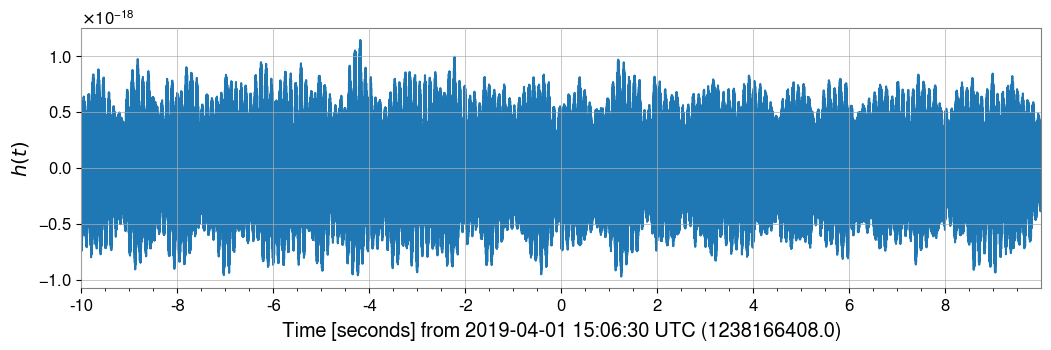

In [62]:
ts.plot(epoch=o3_gps, ylabel='$h(t)$');

It works like magic! We don't need to specify the file, just the channel name and the GPS time range.

It is also possible to use `gwpy.TimeSeries.find` instead of the `get` method. The only difference is that `find` limits itself to local data frames, while `get` runs the `find` method, and if no local data is found, tries to get the data from a remote NDS2 server.

Now let's try with O4 data. This should not run without having a SciToken.

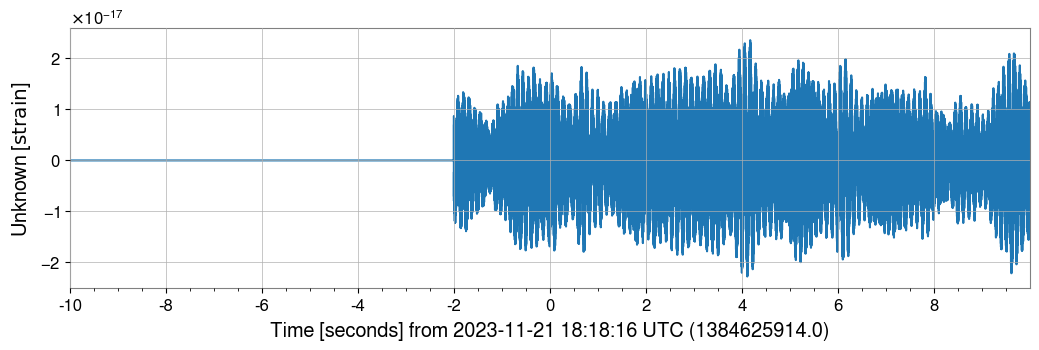

In [64]:
o4_gps = 1384625914
ts = TimeSeries.get("V1:Hrec_hoft_16384Hz", o4_gps-10, o4_gps+10,)
ts.plot(epoch=o4_gps);

## How to access Omicron triggers in CIT?

There is a useful library, `gwtrigfind`, which is available in the `igwn` environments.

*Notes:* (raised by Nicolas Arnaud on https://git.ligo.org/virgo/detchar/detchar-help/-/issues/9)  

1) The `Omicron` triggers available at EGO (or CC-IN2P3) are not necessarily the same (and very likely not the same) than those available at CIT, as they have been generated independently.  
2) Also, the Omicron ROOT files produced at EGO or CC-IN2P3 contain the Omicron triggers in addition to the Omicron clusters (that we call triggers improperly), while only the clusters are stored on the LIGO side.

In [65]:
from gwtrigfind import find_trigger_files

In [66]:
ch = "V1:Hrec_hoft_16384Hz"

In [67]:
# to_gps is a nice util to get gps times from dates
from gwpy.time import to_gps

O4a_start = to_gps("24 May 2023 15:00 UTC")
O4a_end = to_gps("16 Jan 2024 16:00 UTC")

O4a_start.gpsSeconds, O4a_end.gpsSeconds

(1368975618, 1389456018)

Using the `find_trigger_files` function, one can automatically find the location of the relevant trigger files for Omicron (or other ETGs)

for O4:

In [68]:
trigfiles = find_trigger_files(ch, 'Omicron', O4a_start, O4a_end)
trigfiles

['file:///home/detchar/triggers/V1/Hrec_hoft_16384Hz_OMICRON/13846/V1-Hrec_hoft_16384Hz_OMICRON-1384629626-720.h5',
 'file:///home/detchar/triggers/V1/Hrec_hoft_16384Hz_OMICRON/13846/V1-Hrec_hoft_16384Hz_OMICRON-1384627587-658.h5',
 'file:///home/detchar/triggers/V1/Hrec_hoft_16384Hz_OMICRON/13846/V1-Hrec_hoft_16384Hz_OMICRON-1384630346-248.h5',
 'file:///home/detchar/triggers/V1/Hrec_hoft_16384Hz_OMICRON/13846/V1-Hrec_hoft_16384Hz_OMICRON-1384626026-240.h5',
 'file:///home/detchar/triggers/V1/Hrec_hoft_16384Hz_OMICRON/13846/V1-Hrec_hoft_16384Hz_OMICRON-1384643742-1180.h5',
 'file:///home/detchar/triggers/V1/Hrec_hoft_16384Hz_OMICRON/13846/V1-Hrec_hoft_16384Hz_OMICRON-1384627107-240.h5',
 'file:///home/detchar/triggers/V1/Hrec_hoft_16384Hz_OMICRON/13846/V1-Hrec_hoft_16384Hz_OMICRON-1384626266-841.h5',
 'file:///home/detchar/triggers/V1/Hrec_hoft_16384Hz_OMICRON/13846/V1-Hrec_hoft_16384Hz_OMICRON-1384628245-480.h5',
 'file:///home/detchar/triggers/V1/Hrec_hoft_16384Hz_OMICRON/13846/V1-H

Then, these events can be loaded into a table using

In [78]:
from gwpy.table import EventTable
gltab = EventTable.read(trigfiles, path="triggers")

This table can be sorted or filtered using the `.sort()` and `.filter()` methods, and also converted to a Pandas dataframe:

In [81]:
gltab.sort('time')  # in-place operation
filtered_gltab = gltab.filter("snr>7.5")
gldf = filtered_gltab.to_pandas()
gldf

,time,frequency,tstart,tend,fstart,fend,snr,q,amplitude,phase
0,1.384626e+09,999.041898,1.384626e+09,1.384626e+09,16.000000,7950.482748,3649.552815,109.179646,4.535325e-19,2.891837
1,1.384626e+09,665.449753,1.384626e+09,1.384626e+09,41.163443,7391.958550,7.829776,109.179646,3.622942e-22,1.869625
2,1.384626e+09,813.447647,1.384626e+09,1.384626e+09,145.358737,7875.707575,8.050834,57.841897,4.370829e-22,2.243517
3,1.384626e+09,89.760414,1.384626e+09,1.384626e+09,52.197008,865.789470,10.286116,109.179646,1.933239e-22,0.919482
4,1.384626e+09,159.776185,1.384626e+09,1.384626e+09,41.193534,6581.352585,8.257867,16.234698,2.209741e-22,1.774540
...,...,...,...,...,...,...,...,...,...,...
1402,1.385161e+09,23.020820,1.385161e+09,1.385161e+09,16.000000,7950.482748,77.341312,109.179646,1.047295e-20,1.654672
1403,1.385161e+09,24.757046,1.385161e+09,1.385161e+09,16.000000,7950.482748,36.494603,57.841897,4.052263e-21,1.336944
1404,1.385161e+09,7267.855555,1.385161e+09,1.385161e+09,45.904301,7950.482748,11.428240,109.179646,8.535547e-21,1.782513
1405,1.385161e+09,5375.653169,1.385161e+09,1.385161e+09,1145.751672,7875.707575,8.637255,30.643853,4.218006e-21,1.309017


for O3:

In [82]:
o3a_start = 1238166018
trigfiles = find_trigger_files(ch, 'Omicron', o3a_start, o3a_start+10000)
len(trigfiles)

55

In [83]:
from gwpy.table import EventTable
gltab = EventTable.read(trigfiles, path="triggers")
gltab.sort('time')  # in-place operation

In [85]:
import pandas as pd
filtered_gltab = gltab.filter("snr>7.5")
gldf = filtered_gltab.to_pandas()
pd.concat([gldf.head(), gldf.tail()])

,time,frequency,tstart,tend,fstart,fend,snr,q,amplitude,phase
0,1.238166e+09,118.525946,1.238166e+09,1.238166e+09,45.904301,377.850642,12.088338,4.556653,1.093108e-22,1.977364
1,1.238167e+09,19.950423,1.238167e+09,1.238167e+09,16.000000,24.390086,7.866979,16.234698,2.586624e-21,0.037100
2,1.238167e+09,41.312363,1.238167e+09,1.238167e+09,24.390086,106.669459,8.179652,4.556653,2.461123e-22,-0.440632
3,1.238167e+09,19.056470,1.238167e+09,1.238167e+09,18.150191,20.589339,8.305787,109.179646,3.293779e-21,1.294096
4,1.238168e+09,340.202230,1.238168e+09,1.238168e+09,247.871621,466.516322,12.113068,109.179646,1.967026e-22,2.937091
21,1.238171e+09,975.618932,1.238171e+09,1.238171e+09,131.700302,3840.021281,27.946740,4.556653,7.754540e-22,2.420946
22,1.238172e+09,26.029853,1.238172e+09,1.238172e+09,25.427619,27.358604,8.068436,109.179646,8.416854e-22,-0.009986
23,1.238172e+09,7913.006837,1.238172e+09,1.238172e+09,6386.713125,7950.482748,7.671208,109.179646,2.204124e-21,-2.481099
24,1.238175e+09,19.950423,1.238175e+09,1.238175e+09,16.000000,24.390086,7.779762,16.234698,2.394806e-21,-1.185773
25,1.238176e+09,25.672876,1.238176e+09,1.238176e+09,19.754528,30.113416,7.544270,16.234698,8.199441e-22,-1.627407


## How to download a GravitySpy table?

First, make sure you have the following environment variables set up:
- `GRAVITYSPY_DATABASE_USER`
- `GRAVITYSPY_DATABASE_PASSWD`

These can be found at https://secrets.ligo.org/secrets/144/

Then, you can use `gwpy.table.GravitySpyTable.fetch()`, as explained in the [docs](https://gwpy.github.io/docs/stable/table/io/#accessing-gravityspy-events).  
Using this, you can filter e.g. on the interferometer and the GPS times.

In [86]:
o3a_start = 1238166018

from gwpy.table import GravitySpyTable
gspy_table = GravitySpyTable.fetch('gravityspy', 'glitches', 
                              selection=['ifo = V1', f'{o3a_start}<event_time<{o3a_start+10_000}'])
gspy_table

event_time,ifo,peak_time,peak_time_ns,start_time,start_time_ns,duration,search,process_id,event_id,peak_frequency,central_freq,bandwidth,channel,amplitude,snr,confidence,chisq,chisq_dof,param_one_name,param_one_value,gravityspy_id,Air_Compressor,Blip,Chirp,Extremely_Loud,Helix,Koi_Fish,Light_Modulation,Low_Frequency_Burst,Low_Frequency_Lines,No_Glitch,None_of_the_Above,Paired_Doves,Power_Line,Repeating_Blips,Scattered_Light,Scratchy,Tomte,Violin_Mode,Wandering_Line,Whistle,ml_label,workflow,subjectset,Filename1,Filename2,Filename3,Filename4,upload_flag,1400Ripples,1080Lines,image_status,data_quality,citizen_score,url1,url2,url3,url4,links_subjects,q_value,ml_confidence,vco
float64,str2,int64,int64,int64,int64,float64,str7,int64,int64,float64,float64,float64,str17,float64,float64,int64,int64,int64,str5,float64,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,int64,int64,str87,str87,str87,str87,float64,float64,float64,str7,str7,float64,str108,str108,str108,str108,float64,float64,float64,float64
1238166944.94922,V1,1238166944,949218034,1238166944,921875000,0.0781200006604195,OMICRON,0,534,41.3123588562012,65.5297698974609,82.2793731689453,Hrec_hoft_16384Hz,2.46112005898021e-22,8.17965030670166,0,0,0,phase,-0.44063,7Rmzlmneu5,2.07914808925125e-06,0.999705374240875,1.98679302343407e-07,1.98123863981436e-08,2.28086154407947e-08,1.70277019151399e-07,2.10602092920453e-06,3.98439716775556e-08,1.43025971510724e-07,6.66676100991026e-07,1.47760310937883e-05,1.52865780478351e-07,1.17074500849412e-06,6.18852891420829e-06,3.50245628055745e-08,2.91118681161606e-07,0.000265872338786721,3.87359676778942e-07,7.70161676655334e-08,8.48168091316381e-10,Blip,1610,67414,/home/gravityspy/public_html/runs/O3/Virgo/JliKNEwsDM/V1_7Rmzlmneu5_spectrogram_0.5.png,/home/gravityspy/public_html/runs/O3/Virgo/JliKNEwsDM/V1_7Rmzlmneu5_spectrogram_1.0.png,/home/gravityspy/public_html/runs/O3/Virgo/JliKNEwsDM/V1_7Rmzlmneu5_spectrogram_2.0.png,/home/gravityspy/public_html/runs/O3/Virgo/JliKNEwsDM/V1_7Rmzlmneu5_spectrogram_4.0.png,1.0,1.03090025405095e-08,2.05863926794336e-07,testing,no_flag,0.0,https://panoptes-uploads.zooniverse.org/production/subject_location/c2dbfa60-412a-4513-9e2f-3c786b108053.png,https://panoptes-uploads.zooniverse.org/production/subject_location/ee194b7e-e83c-4cce-8da0-0d42753f9f39.png,https://panoptes-uploads.zooniverse.org/production/subject_location/78824dab-db2e-4efe-a2ab-8913f8976f21.png,https://panoptes-uploads.zooniverse.org/production/subject_location/07bce042-223b-444a-85d8-ebd5ce4b66d4.png,40472833.0,5.65685424949238,0.999705374240875,1e+20
1238168518.92969,V1,1238168518,929687023,1238168518,609375000,0.578119993209839,OMICRON,0,1406,340.202239990234,353.844207763672,444.287811279297,Hrec_hoft_16384Hz,3.51492993353041e-22,21.4924392700195,0,0,0,phase,-0.38033,BjhTPVb9WB,3.61653746949742e-06,4.17677983932663e-05,1.24662426514988e-06,4.37764674643404e-06,1.41545035603485e-06,0.000229662007768638,3.33360958393314e-07,9.5577028957905e-08,4.09626599306989e-09,8.00952602730831e-06,0.000109613945824094,3.67794661393361e-09,4.77635211382221e-08,1.01761979749426e-05,2.51819471941417e-08,1.92831867025234e-05,8.39481995029701e-09,6.77057840903217e-08,0.00203076028265059,0.997539281845093,Whistle,1610,67456,/home/gravityspy/public_html/runs/O3/Virgo/JliKNEwsDM/V1_BjhTPVb9WB_spectrogram_0.5.png,/home/gravityspy/public_html/runs/O3/Virgo/JliKNEwsDM/V1_BjhTPVb9WB_spectrogram_1.0.png,/home/gravityspy/public_html/runs/O3/Virgo/JliKNEwsDM/V1_BjhTPVb9WB_spectrogram_2.0.png,/home/gravityspy/public_html/runs/O3/Virgo/JliKNEwsDM/V1_BjhTPVb9WB_spectrogram_4.0.png,1.0,7.48226369751137e-08,1.7790561912534e-07,testing,no_flag,0.0,https://panoptes-uploads.zooniverse.org/production/subject_location/f8efdb1f-401a-4909-b1e9-b0cb5b870e4e.png,https://panoptes-uploads.zooniverse.org/production/subject_location/c5d6ae3b-1e62-414c-a173-37c6afa347

Like the Omicron table, this table can also be filtered, sorted and converted to pandas format:

In [87]:
gspy_table.sort('event_time')  # in-place operation
filtered_table = gspy_table.filter('snr>10')
gspy_df = filtered_table.to_pandas()
gspy_df

,event_time,ifo,peak_time,peak_time_ns,start_time,start_time_ns,duration,search,process_id,event_id,...,data_quality,citizen_score,url1,url2,url3,url4,links_subjects,q_value,ml_confidence,vco
0,1.238166e+09,V1,1238166408,178710937,1238166408,156250000,0.09375,OMICRON,0,243,...,no_flag,0.0,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,40472835.0,5.656854,0.999769,1.000000e+20
1,1.238168e+09,V1,1238168111,523437023,1238168111,437500000,0.31250,OMICRON,0,1151,...,no_flag,0.0,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,40472880.0,45.254834,0.999746,1.000000e+20
2,1.238168e+09,V1,1238168121,867187023,1238168121,781250000,0.26099,OMICRON,0,1156,...,no_flag,0.0,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,40472873.0,22.627417,0.999957,1.000000e+20
3,1.238168e+09,V1,1238168134,429687023,1238168134,312500000,0.43750,OMICRON,0,1167,...,no_flag,0.0,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,40472875.0,22.627417,0.999959,1.000000e+20
4,1.238168e+09,V1,1238168137,289062023,1238168137,187500000,0.35938,OMICRON,0,1169,...,no_flag,0.0,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,40472874.0,22.627417,0.999607,1.000000e+20
5,1.238168e+09,V1,1238168379,257812023,1238168378,859375000,0.98438,OMICRON,0,1321,...,no_flag,0.0,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,40472882.0,45.254834,0.951163,1.000000e+20
6,1.238168e+09,V1,1238168381,335937023,1238168381,218750000,0.65625,OMICRON,0,1323,...,no_flag,0.0,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,40472881.0,45.254834,0.809453,1.000000e+20
7,1.238169e+09,V1,1238168518,929687023,1238168518,609375000,0.57812,OMICRON,0,1406,...,no_flag,0.0,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,40472872.0,45.254834,0.997539,1.000000e+20
8,1.238169e+09,V1,1238168521,273437023,1238168521,187500000,0.45312,OMICRON,0,1409,...,no_flag,0.0,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,40472879.0,45.254834,0.998786,1.000000e+20
9,1.238169e+09,V1,1238168527,398437023,1238168527,312500000,0.25000,OMICRON,0,1414,...,no_flag,0.0,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,40472878.0,45.254834,0.999291,1.000000e+20


A more incomplete table with GravitySpy classifications can also be obtained from the [GlitchDB](https://ldvw.ligo.caltech.edu/ldvw/gspySearch), which allows to filter on the interferometer and the run, and then click on "Download CSV".